In [5]:
import os
os.chdir('../../')
os.getcwd()

'/data/jeff-law/projects/toxcast/2019-08-toxcast'

In [164]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))

# Extra settings for the matplotlib text to be editable in inkscape
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
%matplotlib inline  

python version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
matplotlib version: 3.1.3
seaborn version: 0.9.0
pandas version: 0.23.0
numpy version: 1.17.2


In [68]:
# first load the selected enriched terms, and the hits enriched terms
results_dir = "outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis/"
hits_file = "%s/hits/3chemical-hits-sig-terms-bonferroni-c0_05.tsv" % (results_dir)
revigo_files = {
    "C75330755": "%s/revigo/lovastatin/lovastatin-revigo.csv" % results_dir,
    "C6893023": "%s/revigo/t3/t3-revigo.csv" % results_dir,
    "C80057": "%s/revigo/bpa/bpa-revigo.csv" % results_dir,
}
revigo_selected_terms_files = {
    "C75330755": "%s/revigo/lovastatin/revigo-lovastatin-selected-terms.csv" % results_dir,
    "C6893023": "%s/revigo/t3/t3-revigo-selected-terms.csv" % results_dir,
    "C80057": "%s/revigo/bpa/bpa-revigo-selected-terms.csv" % results_dir,
}

hits_df = pd.read_csv(hits_file, sep='\t', index_col=0)
hits_df.head()

,Term,GOID,Bonferroni
Chemical,,,
C75330755,positive regulation of transcription from RNA ...,GO:0045944,5.613475e-55
C75330755,steroid hormone mediated signaling pathway,GO:0043401,1.718024e-38
C75330755,"positive regulation of transcription, DNA-temp...",GO:0045893,1.855001e-32
C75330755,transcription initiation from RNA polymerase I...,GO:0006367,1.490042e-29
C75330755,negative regulation of transcription from RNA ...,GO:0000122,3.094254e-24


In [95]:
# also read in the frequency of the terms among the networks
counts_file = "%s/325chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
df_counts = pd.read_csv(counts_file, sep='\t', header=None, names=['term', 'count'], index_col='term')
df_counts.head()

,count
term,
"positive regulation of transcription, DNA-templated",328
negative regulation of apoptotic process,328
positive regulation of transcription from RNA polymerase II promoter,328
viral process,328
negative regulation of cell proliferation,320


246.0
outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis//viz/C75330755-full-enrichment-heatmap.pdf


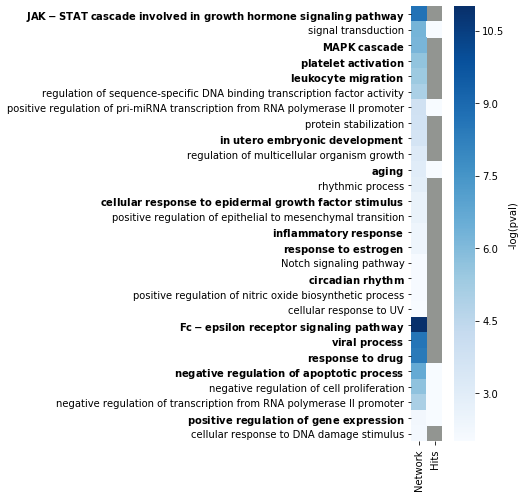

246.0
outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis//viz/C6893023-full-enrichment-heatmap.pdf


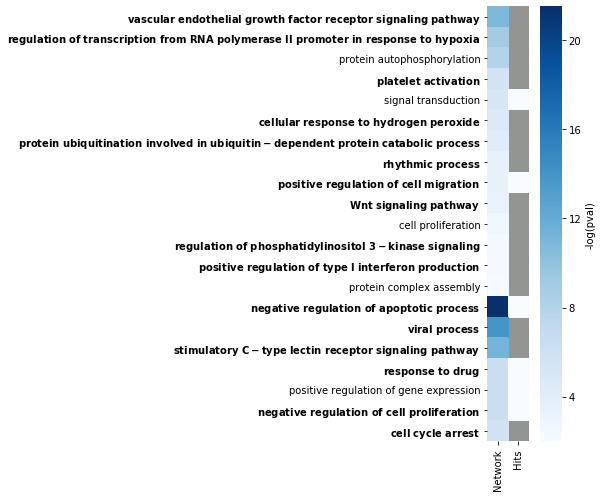

246.0
outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis//viz/C80057-full-enrichment-heatmap.pdf


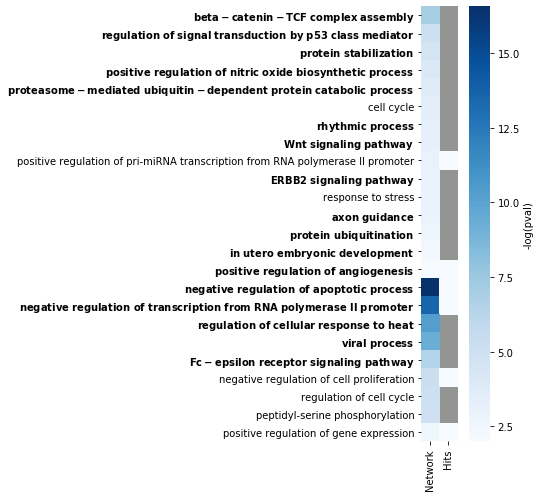

,description,frequency,plot_X,plot_Y,plot_size,log10 p-value,uniqueness,dispensability,representative,eliminated,count,selected,hits
term_ID,,,,,,,,,,,,,
GO:1904837,beta-catenin-TCF complex assembly,0.179%,2.344,5.630,1.505,7.0605,0.952,0.002,1904837,0,125,1.0,NaN
GO:1901796,regulation of signal transduction by p53 class...,0.964%,2.927,-6.227,2.225,5.0809,0.793,0.261,1901796,0,240,1.0,NaN
GO:0050821,protein stabilization,0.866%,6.579,1.510,2.179,4.6576,0.896,0.034,50821,0,195,1.0,NaN
GO:0045429,positive regulation of nitric oxide biosynthet...,0.237%,-2.777,-6.532,1.623,4.0555,0.763,0.044,45429,0,68,1.0,NaN
GO:0043161,proteasome-mediated ubiquitin-dependent protei...,2.222%,-2.709,6.003,2.587,3.7959,0.807,0.226,43161,0,173,1.0,NaN


In [165]:
for chem, revigo_file in revigo_files.items():
    df = pd.read_csv(revigo_file)
    df.set_index('description', inplace=True, drop=False)
    df['count'] = df_counts['count']
    df.set_index('term_ID', inplace=True)
    df = df[df['eliminated'] == 0]
    df_sel = pd.read_csv(revigo_selected_terms_files[chem], index_col='term_ID')
    df_sel['selected'] = 1
    df['selected'] = df_sel['selected']
#     df['description'] = df['description'].apply(lambda x: r"\textbf{%s}" % x)
    # split into two groups, sort the two groups, then put back together
    split_count = df_counts['count'].max() *.75
    print(split_count)
    df2 = df[df['count'] < split_count].sort_values('log10 p-value')
    df3 = df[df['count'] >= split_count].sort_values('log10 p-value')
    df = pd.concat([df2, df3])
    df['log10 p-value'] = abs(df['log10 p-value'])
    enrichment_heatmap(chem, df, chem_hits_df, results_dir+'/viz')
df.head()

In [162]:
def enrichment_heatmap(chem, df, chem_hits_df, out_dir):
    chem_hits_df = hits_df[hits_df.index == chem].set_index('GOID')
#     df.set_index('term_ID', inplace=True)
    df['hits'] = chem_hits_df['Bonferroni']
    plot_df = df[['description', 'log10 p-value', 'hits']].set_index('description')
    plot_df.columns = ["Network", "Hits"]
    # plot_df = df[['term_ID', 'log10 p-value']].set_index('term_ID')
    plot_df.head()
    # now make a heatmap
    f, ax = plt.subplots(figsize=(4,8))
    # curr_cmap = sns.color_palette('Blues')
    # curr_cmap.set_bad(color='gray')
    sns.heatmap(plot_df, cmap='Blues', square=True, 
                vmin =2, cbar_kws={'label': '-log(pval)'}, ax=ax)
    ax.set_facecolor('xkcd:grey')
    plt.ylabel("")
    
    # try to make some labels bold
    labels = [l.get_text() for l in ax.get_yticklabels()]
    sel_terms = df[df['selected'] == 1]['description'].values
    labels = [' '.join(r"$\bf{%s}$"%t for t in t.split(' ')) if t in sel_terms else t for t in labels]
    ax.set_yticklabels(labels)

    out_file = "%s/%s-full-enrichment-heatmap.pdf" % (out_dir, chem)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    print(out_file)
    plt.savefig(out_file, bbox_inches='tight')
    plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
    plt.show()
    plt.close()


# Heatmap of terms common to at least 50% of networks

In [219]:
# also read in the frequency of the terms among the networks
# counts_file = "%s/325chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
revigo_counts_file = "/home/jeffl/Sync/lab-sync/projects/toxcast/outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis/325chemicals-common-terms-c0_5-revigo.csv"
df = pd.read_csv(revigo_counts_file, index_col=['term_ID', 'description'])
df = df[df['eliminated'] == 0]
df['fraction'] = df['value'] / df['value'].max()
print("%d terms" % (len(df)))
df_counts = df
df_counts.head()

18 terms


,,frequency,plot_X,plot_Y,plot_size,value,uniqueness,dispensability,representative,eliminated,fraction
term_ID,description,,,,,,,,,,
GO:0016032,viral process,4.091%,0.540,7.653,2.851,325.0,0.939,0.000,16032,0,1.000000
GO:0042493,response to drug,2.366%,3.812,5.104,2.614,316.0,0.878,0.000,42493,0,0.972308
GO:0048511,rhythmic process,1.812%,0.283,-7.514,2.498,182.0,0.943,0.000,48511,0,0.560000
GO:0018105,peptidyl-serine phosphorylation,1.587%,-7.717,1.421,2.441,292.0,0.763,0.003,18105,0,0.898462
GO:0043066,negative regulation of apoptotic process,4.749%,-3.653,3.865,2.916,325.0,0.734,0.003,43066,0,1.000000


In [220]:
# and among the hits
# counts_file = "%s/hits/325chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
revigo_counts_file = "/home/jeffl/Sync/lab-sync/projects/toxcast/outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis/hits/325chemicals-common-terms-c0_5-revigo.csv"
df = pd.read_csv(revigo_counts_file, index_col=['term_ID', 'description'])
df = df[df['eliminated'] == 0]
df['hits_fraction'] = df['value'] / df['value'].max()
print("%d terms" % (len(df)))
df_counts_hits = df
df_counts_hits.head()

18 terms


,,frequency,plot_X,plot_Y,plot_size,value,uniqueness,dispensability,representative,eliminated,hits_fraction
term_ID,description,,,,,,,,,,
GO:0000122,negative regulation of transcription from RNA polymerase II promoter,4.380%,-5.077,-0.119,2.881,325.0,0.534,0.000,122,0,1.000000
GO:0007568,aging,1.633%,-1.601,6.730,2.453,183.0,0.914,0.000,7568,0,0.563077
GO:1904837,beta-catenin-TCF complex assembly,0.179%,1.590,6.886,1.505,232.0,0.927,0.002,1904837,0,0.713846
GO:0042593,glucose homeostasis,1.252%,-0.291,-7.772,2.338,325.0,0.875,0.035,42593,0,1.000000
GO:0030522,intracellular receptor signaling pathway,1.581%,4.287,1.732,2.439,325.0,0.801,0.055,30522,0,1.000000


In [266]:
# now make a heatmap, where we sort by the maximum fraction among hits or net
# df = df_counts[['description', 'fraction']]
# df['hits_fraction'] = df_counts_hits['fraction']
df = pd.concat([df_counts[['fraction']],df_counts_hits[['hits_fraction']]], axis=1)
df['fraction'] = df['fraction'].replace(np.nan,-1)
df['max_frac'] = df.sum(axis=1)
df['fraction'] = df['fraction'].replace(-1,np.nan)
df.sort_values(by='max_frac', inplace=True, ascending=False) 
df.drop(columns='max_frac', inplace=True)
df.index = df.index.get_level_values('description')
# df.index = [x.replace('negative','neg.').replace('positive','pos.').replace('regulation', 'reg.') for x in df.index]
df.head()


,fraction,hits_fraction
description,,
negative regulation of apoptotic process,1.000000,1.000000
negative regulation of cell proliferation,0.978462,1.000000
negative regulation of transcription from RNA polymerase II promoter,0.972308,1.000000
positive regulation of gene expression,0.947692,1.000000
response to drug,0.972308,0.753846


outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis//viz/overlap-enrichment-heatmap.pdf


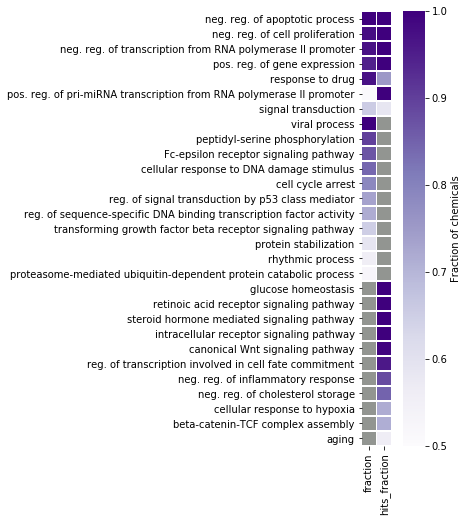

In [239]:
# now make a heatmap
f, ax = plt.subplots(figsize=(4,8))
# curr_cmap = sns.color_palette('Blues')
# curr_cmap.set_bad(color='gray')
# sns.heatmap(df, cmap='YlOrBr', square=True, 
sns.heatmap(df, cmap='Purples', square=True, linewidths=0.5,
            vmin=0.5, cbar_kws={'label': 'Fraction of chemicals'}, ax=ax)
ax.set_facecolor('xkcd:grey')
plt.ylabel("")

out_dir = results_dir+'/viz'
out_file = "%s/overlap-enrichment-heatmap.pdf" % (out_dir)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()


# Try also loading the functions present in CTD

In [240]:
def get_chemical_map(toxcast_data):
    """
    Map the chemical ID used in ToxCast to the CAS RN 
    """
    print("reading %s" % (toxcast_data.chemical_summary_file))
    df = pd.read_csv(toxcast_data.chemical_summary_file, header=0)
    cols = df.columns
    chemIDtoCAS  = dict(zip(df[cols[3]], df[cols[2]]))
    chemCAStoID  = dict(zip(df[cols[2]], df[cols[3]]))
    return chemIDtoCAS, chemCAStoID

In [241]:
import sys
sys.path.append("./src/")
import toxcast_utils as t_utils

kwargs = {}
kwargs['chem_func_file'] = "inputs/ctd/2020-09-23/CTD_chem_go_enriched.tsv.gz"
kwargs['chemicals'] = "inputs/versions/2018_01-toxcast-d2d-p1_5-u1_25/sig-chemicals.txt"
chemicals = pd.read_csv(kwargs['chemicals'], sep='\t', header=None, comment='#')[0].tolist()
toxcast_data = t_utils.loadToxcastData()
chemIDtoCAS, chemCAStoID = get_chemical_map(toxcast_data)

func_col = kwargs.get('chem_func_col',4)
print("reading %s, using col %s" % (kwargs['chem_func_file'], func_col))
df_func = pd.read_csv(
    kwargs['chem_func_file'], sep='\t', compression='gzip', comment='#',
    header=None,
)
print(df_func.head())
df_func[2] = df_func[2].apply(lambda x: chemCAStoID.get(x))
df_func = df_func[df_func[2].isin(chemicals)]
chemicals_with_func = df_func[2].unique()
print("\t%d/%d significant chemicals are in this file" % (len(chemicals_with_func), len(chemicals)))

loading chemical map
reading inputs/toxcast-tox21-v3/Chemical_Summary_190708.csv
reading inputs/toxcast-tox21-v3/parsed/chem_rec_tfs.gmt. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/parsed/chem_prot_hits.csv. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/parsed/chem_prot_zscores.csv. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/chemical_types.tsv
reading inputs/toxcast-tox21-v3/Chemical_Summary_190708.csv
reading inputs/ctd/2020-09-23/CTD_chem_go_enriched.tsv.gz, using col 4
         0        1    2                   3   \
0  10074-G5  C534883  NaN  Biological Process   
1  10074-G5  C534883  NaN  Biological Process   
2  10074-G5  C534883  NaN  Molecular Function   
3  10074-G5  C534883  NaN  Molecular Function   
4  10074-G5  C534883  NaN  Molecular Function   

                                                  4           5   6   \
0  negative regulation of nitrogen compound metab...  GO:0051172   3   
1                      urogenital system d

NameError: name 'chemicals_with_func' is not defined

In [242]:
chemicals_with_func = df_func[2].unique()
print("\t%d/%d significant chemicals are in this file" % (len(chemicals_with_func), len(chemicals)))

	134/325 significant chemicals are in this file


In [246]:
# df_func['func_count'] = 
ctd_fracs = df_func[func_col].value_counts() / len(chemicals_with_func)
ctd_fracs = ctd_fracs[ctd_fracs > 0.5]
ctd_fracs

response to chemical                                           0.768657
cellular response to chemical stimulus                         0.768657
response to stimulus                                           0.731343
cellular response to stimulus                                  0.723881
regulation of biological quality                               0.716418
metabolic process                                              0.708955
response to organic substance                                  0.708955
organic substance metabolic process                            0.701493
cellular metabolic process                                     0.701493
primary metabolic process                                      0.694030
biological regulation                                          0.694030
cellular process                                               0.686567
response to oxygen-containing compound                         0.679104
binding                                                        0

In [248]:
df2 = df.copy()
df2['ctd_fracs'] = ctd_fracs
df2

,fraction,hits_fraction,ctd_fracs
neg. reg. of apoptotic process,1.000000,1.000000,NaN
neg. reg. of cell proliferation,0.978462,1.000000,NaN
neg. reg. of transcription from RNA polymerase II promoter,0.972308,1.000000,NaN
pos. reg. of gene expression,0.947692,1.000000,NaN
response to drug,0.972308,0.753846,0.619403
pos. reg. of pri-miRNA transcription from RNA polymerase II promoter,0.510769,1.000000,NaN
signal transduction,0.655385,0.587692,0.582090
viral process,1.000000,NaN,NaN
peptidyl-serine phosphorylation,0.898462,NaN,NaN
Fc-epsilon receptor signaling pathway,0.867692,NaN,NaN


In [262]:
# also try overlap of chemicals in general
df_func = pd.read_csv(
    kwargs['chem_func_file'], sep='\t', compression='gzip', comment='#',
    header=None,
)

In [259]:
# # limit to chemicals with at least 25 or more terms
# num_terms = df_func[0].value_counts()
# df_func = df_func[df_func[0].isin((num_terms >= 25).index)]
# print(len(df_func))

6065552


In [261]:
ctd_fracs = df_func[func_col].value_counts() / len(df_func[0].unique())
ctd_fracs = ctd_fracs[ctd_fracs > 0.5]
ctd_fracs

cellular response to chemical stimulus    0.567754
response to chemical                      0.563244
response to organic substance             0.538868
response to oxygen-containing compound    0.537140
cellular response to stimulus             0.518426
response to drug                          0.518138
response to stimulus                      0.516603
cellular response to organic substance    0.515259
response to stress                        0.505950
regulation of biological quality          0.503839
Name: 4, dtype: float64

In [269]:
ctd_counts = df_func[func_col].value_counts()
ctd_counts = ctd_counts[ctd_counts.index.isin(df.index)]
ctd_counts = ctd_counts[ctd_counts >= 1000]
print("%d terms" % (len(ctd_counts)))
ctd_counts

20 terms


response to drug                                                     5399
signal transduction                                                  4811
negative regulation of apoptotic process                             4416
positive regulation of gene expression                               4007
aging                                                                3517
negative regulation of cell proliferation                            3442
peptidyl-serine phosphorylation                                      3002
cellular response to DNA damage stimulus                             2738
viral process                                                        2712
rhythmic process                                                     2400
cellular response to hypoxia                                         2081
cell cycle arrest                                                    1994
intracellular receptor signaling pathway                             1948
glucose homeostasis                   

In [270]:
df2 = df.copy()
df2['CTD count'] = ctd_counts
df2.head()

,fraction,hits_fraction,CTD count
description,,,
negative regulation of apoptotic process,1.000000,1.000000,4416.0
negative regulation of cell proliferation,0.978462,1.000000,3442.0
negative regulation of transcription from RNA polymerase II promoter,0.972308,1.000000,NaN
positive regulation of gene expression,0.947692,1.000000,4007.0
response to drug,0.972308,0.753846,5399.0


In [271]:

df2.index = [x.replace('negative','neg.').replace('positive','pos.').replace('regulation', 'reg.') for x in df2.index]

outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis//viz/overlap-enrichment-heatmap-ctd.pdf


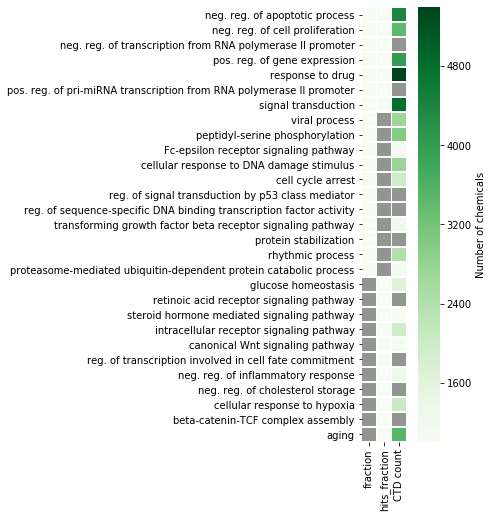

In [274]:
# now make a heatmap
f, ax = plt.subplots(figsize=(4,8))
# curr_cmap = sns.color_palette('Blues')
# curr_cmap.set_bad(color='gray')
# sns.heatmap(df, cmap='YlOrBr', square=True, 
# sns.heatmap(df2['CTD count'], cmap='Greens', square=True, linewidths=0.5,
sns.heatmap(df2, cmap='Greens', square=True, linewidths=0.5,
            vmin=1000, cbar_kws={'label': 'Number of chemicals'}, ax=ax)
ax.set_facecolor('xkcd:grey')
plt.ylabel("")

out_dir = results_dir+'/viz'
out_file = "%s/overlap-enrichment-heatmap-ctd.pdf" % (out_dir)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()
